In [47]:
# STACKED PAIR MAP

Stacking galaxies:   0%|          | 0/13098 [00:00<?, ?it/s]

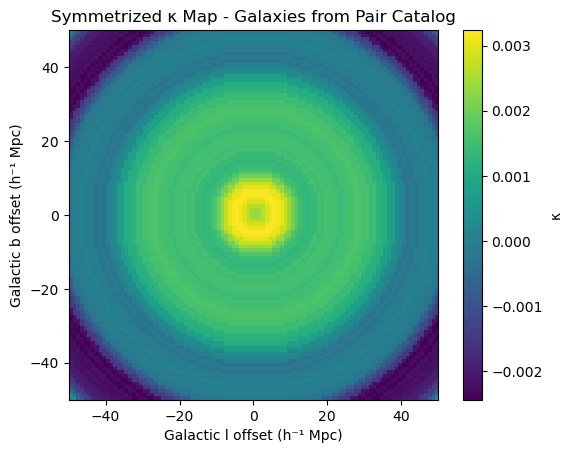

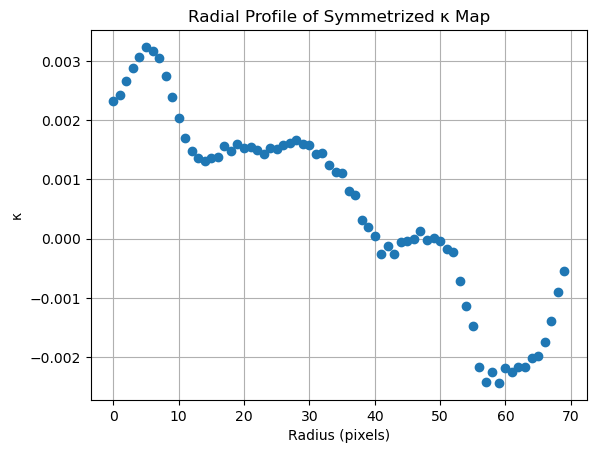

array([ 2.32259596e-03,  2.42315953e-03,  2.65522854e-03,  2.88668253e-03,
        3.06683154e-03,  3.23823243e-03,  3.16982016e-03,  3.05885680e-03,
        2.75015476e-03,  2.38544454e-03,  2.03624161e-03,  1.70083137e-03,
        1.47607631e-03,  1.35642349e-03,  1.30488578e-03,  1.36200457e-03,
        1.37283452e-03,  1.56813691e-03,  1.47459323e-03,  1.59501372e-03,
        1.53738515e-03,  1.54660121e-03,  1.49836100e-03,  1.43343559e-03,
        1.52604405e-03,  1.51242974e-03,  1.58199245e-03,  1.62041141e-03,
        1.66103145e-03,  1.59110445e-03,  1.57864011e-03,  1.43617698e-03,
        1.45148830e-03,  1.24750953e-03,  1.12424490e-03,  1.10783582e-03,
        7.99928064e-04,  7.42780314e-04,  3.15504072e-04,  1.90846092e-04,
        3.97121049e-05, -2.67978391e-04, -1.21972459e-04, -2.57812156e-04,
       -6.29987542e-05, -4.55633093e-05,  1.14479420e-06,  1.20386258e-04,
       -3.08401174e-05,  1.42189229e-05, -4.52702171e-05, -1.73816312e-04,
       -2.33658933e-04, -

In [48]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
import pandas as pd

# --- Settings and constants ---
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0
h = cosmo.h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load pairs catalog ---
pairs = pd.read_csv('data/galaxy_pairs_catalog.csv')

# Extract singular galaxies (concatenate both sides of pairs)
l_all = np.deg2rad(np.concatenate([pairs['l1'], pairs['l2']]))
b_all = np.deg2rad(np.concatenate([pairs['b1'], pairs['b2']]))
z_all = np.concatenate([pairs['z1'], pairs['z2']])
D_all = cosmo.comoving_distance(z_all).value  # Mpc/h

weights = np.ones(len(l_all))  # equal weights

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = np.rad2deg(l) + dl
        b_grid = np.rad2deg(b) + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

# --- Symmetrize map ---
def symmetrize_map(kappa_map):
    y, x = np.indices(kappa_map.shape)
    cx, cy = grid_size // 2, grid_size // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    r_flat = r.ravel()
    kappa_flat = kappa_map.ravel()
    kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)
    sym_map = kappa_avg[r].reshape(kappa_map.shape)
    return sym_map

# --- Radial profile ---
def radial_profile(arr, title, zoom=70):
    y, x = np.indices(arr.shape)
    r = np.sqrt((x - grid_size/2)**2 + (y - grid_size/2)**2).astype(int)
    flat = arr.ravel()
    N = np.bincount(r.ravel())
    S = np.bincount(r.ravel(), weights=flat)
    prof = S / N
    rvals = np.arange(len(prof))[:zoom]
    plt.errorbar(rvals, prof[:zoom], fmt='o', capsize=3)
    plt.title(title)
    plt.xlabel("Radius (pixels)")
    plt.ylabel("κ")
    plt.grid(True)
    plt.show()
    return prof

# --- Run stacking ---
kappa_stack = stack_kappa(l_all, b_all, D_all, weights)
kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_smooth)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - Galaxies from Pair Catalog")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, "Radial Profile of Symmetrized κ Map")


Stacking galaxies:   0%|          | 0/20000 [00:00<?, ?it/s]

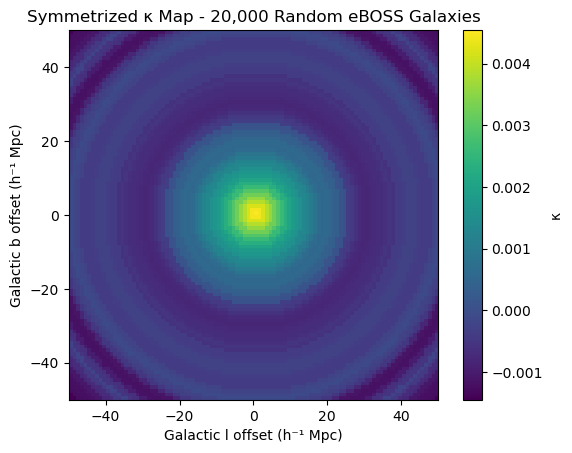

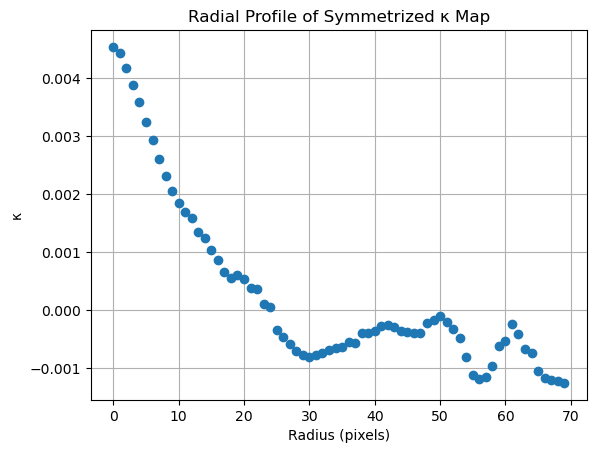

array([ 4.54224521e-03,  4.43181314e-03,  4.17441616e-03,  3.88642600e-03,
        3.59728503e-03,  3.23903775e-03,  2.93807589e-03,  2.61069863e-03,
        2.30952655e-03,  2.06001959e-03,  1.84852095e-03,  1.69824674e-03,
        1.59093410e-03,  1.34263334e-03,  1.24772586e-03,  1.02815469e-03,
        8.66483500e-04,  6.55000635e-04,  5.51237714e-04,  6.04604290e-04,
        5.35975501e-04,  3.88030829e-04,  3.69902291e-04,  1.09405638e-04,
        5.94765353e-05, -3.45364466e-04, -4.63404404e-04, -5.78478919e-04,
       -7.04242473e-04, -7.69531891e-04, -8.03638915e-04, -7.84580901e-04,
       -7.44711244e-04, -6.98992483e-04, -6.56080469e-04, -6.34103303e-04,
       -5.49716425e-04, -5.65526809e-04, -4.03813078e-04, -3.92224559e-04,
       -3.68471621e-04, -2.77053200e-04, -2.63766830e-04, -2.90760933e-04,
       -3.70812220e-04, -3.80474982e-04, -3.94772029e-04, -3.94174778e-04,
       -2.27414742e-04, -1.71296062e-04, -1.12088810e-04, -2.12286261e-04,
       -3.24814580e-04, -

In [49]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter

# --- Settings and constants ---
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0
h = cosmo.h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load original eBOSS catalog ---
real_file = "data/eBOSS/eBOSS_LRG_clustering_data-NGC-vDR16.fits"
with fits.open(real_file) as hd:
    cat = hd[1].data
cat = cat[(cat['Z'] > 0) & np.isfinite(cat['RA']) & np.isfinite(cat['DEC'])]
z_all = cat['Z']
ra_all = cat['RA']
dec_all = cat['DEC']

def fast_icrs_to_galactic(ra_deg, dec_deg):
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    R = np.array([
        [-0.0548755604, -0.8734370902, -0.4838350155],
        [ 0.4941094279, -0.4448296300,  0.7469822445],
        [-0.8676661490, -0.1980763734,  0.4559837762]
    ])
    xg, yg, zg = np.dot(R, np.array([x, y, z]))
    b_rad = np.arcsin(zg)
    l_rad = np.arctan2(yg, xg)
    l_deg = np.degrees(l_rad) % 360
    b_deg = np.degrees(b_rad)
    return l_deg, b_deg

l_all, b_all = fast_icrs_to_galactic(ra_all, dec_all)
D_all = cosmo.comoving_distance(z_all).value  # Mpc/h

# --- Select 20,000 random galaxies ---
num_random = 20000
total_gal = len(l_all)
indices = np.random.choice(total_gal, min(num_random, total_gal), replace=False)

l_rand = l_all[indices]
b_rand = b_all[indices]
D_rand = D_all[indices]
weights_rand = np.ones(len(l_rand))

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

# --- Symmetrize map ---
def symmetrize_map(kappa_map):
    y, x = np.indices(kappa_map.shape)
    cx, cy = grid_size // 2, grid_size // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    r_flat = r.ravel()
    kappa_flat = kappa_map.ravel()
    kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)
    sym_map = kappa_avg[r].reshape(kappa_map.shape)
    return sym_map

# --- Radial profile ---
def radial_profile(arr, title, zoom=70):
    y, x = np.indices(arr.shape)
    r = np.sqrt((x - grid_size/2)**2 + (y - grid_size/2)**2).astype(int)
    flat = arr.ravel()
    N = np.bincount(r.ravel())
    S = np.bincount(r.ravel(), weights=flat)
    prof = S / N
    rvals = np.arange(len(prof))[:zoom]
    plt.errorbar(rvals, prof[:zoom], fmt='o', capsize=3)
    plt.title(title)
    plt.xlabel("Radius (pixels)")
    plt.ylabel("κ")
    plt.grid(True)
    plt.show()
    return prof

# --- Run stacking ---
kappa_stack = stack_kappa(l_rand, b_rand, D_rand, weights_rand)
kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_smooth)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - 20,000 Random eBOSS Galaxies")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, "Radial Profile of Symmetrized κ Map")